In [117]:
import os
import glob
import numpy as np
import pandas as pd
import PIL.Image
import cv2
import h5py
import time
import pickle
from tqdm import tqdm

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing import image

import matplotlib.pyplot as plt

import feature_axis.axis as axis

In [118]:
_path_root =  os.path.dirname(os.path.abspath(''))
_path_sample_jpg = _path_root + '/controlled_generation/feature_axis/assets/samples_jpg/'
_x_file_pattern = 'sample_*.jpg'
_z_file_pattern = 'sample_*_z.npy'
_filename_y = 'sample_y.h5'
_filename_z = 'sample_z.h5'
_stylegan_ffhq_f_gdrive_url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-ffhq-config-f.pkl'
_normalize_feature_direction = True

In [119]:
def gen_time_str():
    return time.strftime("%Y%m%d_%H%M%S", time.gmtime())

In [49]:
x_files = glob.glob(os.path.join(_path_sample_jpg, _x_file_pattern))
x_files.sort()

z_files = glob.glob(os.path.join(_path_sample_jpg, _z_file_pattern))
z_files.sort()

assert len(x_files) == len(z_files), 'same number of Z and X'

In [50]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='sigmoid'))

In [51]:
model.load_weights('acc91_Eyeglasses_Smiling_Wearing_Lipstick_No_Beard_Young')

In [52]:
y_list = []
batch_size = 64
img_batch_list = []
x_files_used = x_files
n = len(x_files_used)
save_freq = 2048

In [53]:
for i, file in tqdm(enumerate(x_files_used)):
    img = np.asarray(PIL.Image.open(file))
    img = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    img_batch_list.append(img)
    
    if (i%batch_size) == (batch_size-1) or i == (n-1):
        img_batch = np.stack(img_batch_list, axis=0)
        y = model.predict(img_batch, batch_size=batch_size)
        y_list.append(y)
        img_batch_list = []
        
        if i % save_freq == 0:
            y_concat = np.concatenate(y_list, axis=0)
            with h5py.File(_filename_y, 'w') as f:
                f.create_dataset('y', data=y_concat)
                
y_concat = np.concatenate(y_list, axis=0)     
with h5py.File(_filename_y, 'w') as f:
    f.create_dataset('y', data=y_concat)

48696it [00:48, 1005.46it/s]


In [69]:
with h5py.File(_filename_y, 'r') as f:
    y = f['y'][:]

with h5py.File(_filename_z, 'r') as f:
    z = f['z'][:]

In [74]:
from custom_gen import StyleGANGenerator
gen = StyleGANGenerator(_stylegan_ffhq_f_gdrive_url)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


In [93]:
img = gen.get_images(np.reshape(z[0], (1,512)))

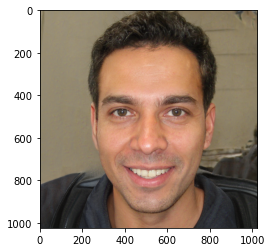

In [94]:
plt.imshow(img[0]/255)

In [102]:
df = pd.read_csv('../datasets/celeba/attributes/attr_celeba.csv').replace({-1:0})[['Eyeglasses', 'Smiling', 'Wearing_Lipstick', 'No_Beard', 'Young']]
df.head()

,Eyeglasses,Smiling,Wearing_Lipstick,No_Beard,Young
0,0,1,1,1,1
1,0,1,0,1,1
2,0,0,0,1,1
3,0,0,1,1,1
4,0,0,1,1,1


In [103]:
y_name = df.columns.to_list()
y_name

['Eyeglasses', 'Smiling', 'Wearing_Lipstick', 'No_Beard', 'Young']

In [110]:
feature_slope = axis.find_feature_axis(z, y)

In [114]:
if _normalize_feature_direction:
    feature_direction = axis.normalize_feature_axis(feature_slope)
else:
    feature_direction = feature_slope

In [123]:
feature_direction_file = 'feature_direction_{}.pkl'.format(gen_time_str())
dict_to_save = {'direction': feature_direction, 'name': y_name}
with open(feature_direction_file, 'wb') as f:
    pickle.dump(dict_to_save, f)